[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/main/tutorials/feature-use/conditional_seasonality_peyton.ipynb)

# Conditional Seasonality
Per default, NeuralProphet models yearly, weekly, and daily seasonalities that remain static throughout all timestamps.
With conditional seasonality, we enable the model to fit seasonalities to certain portions of the dataset.

In [22]:
if "google.colab" in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git@examples_cond_seas # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, df_utils

set_log_level("ERROR")

In [15]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df = pd.read_csv(data_location + "wp_log_peyton_manning.csv")

For example, we can define two weekly seasonalities: one for on-season football, and one for off-season football.
The football season starts in September, and ends after January. We account for this by adding two columns containing binary values (0 and 1) to the input df, depending on whether the condition is activated at a given timestamp or not. Note that also floats between 0..1 can be added to model a softer transition.

As we are defining alternative weekly seasonalities, we disable the model's default one.

In [3]:
df["ds"] = pd.to_datetime(df["ds"])
df["on_season"] = df["ds"].apply(lambda x: x.month in [9, 10, 11, 12, 1])
df["off_season"] = df["ds"].apply(lambda x: x.month not in [9, 10, 11, 12, 1])

period=7 implies that we are adding a new weekly seasonality. With the parameter condition_name= we specify to what condition the newly added seasonality shall be fitted

In [29]:
m = NeuralProphet(weekly_seasonality=False)
m.add_seasonality(name="on_season", period=7, fourier_order=3, condition_name="on_season")
m.add_seasonality(name="off_season", period=7, fourier_order=3, condition_name="off_season")
metrics = m.fit(df, freq="D")

When predicting into the unknown future, the future df must be extended in the same way as the input df.

In [30]:
future = m.make_future_dataframe(df, n_historic_predictions=365, periods=365)
future["on_season"] = future["ds"].apply(lambda x: x.month in [9, 10, 11, 12, 1])
future["off_season"] = future["ds"].apply(lambda x: x.month not in [9, 10, 11, 12, 1])
forecast = m.predict(df=future)

The plot shows both of the newly added weekly seasonalities. In-season we observe a high during the weekends, while during the week there is no game going on. off-season does not show an increase during the weekend.

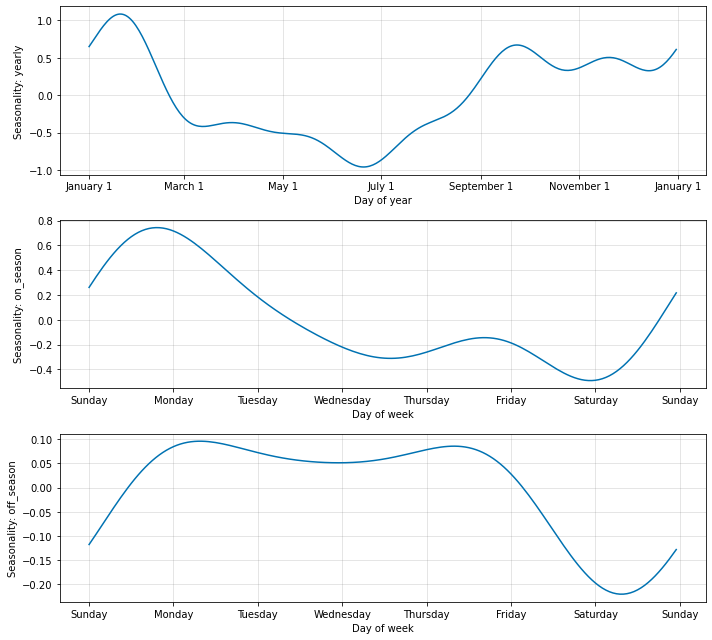

In [6]:
m.plot_parameters(components="seasonality");

NeuralProphet also provides pre-defined conditions (quarters, weekday/weekend) that are added to the input df with a simple function call.
In this case, we would like to incorporate a quarterly changing weekly seasonality.

In [25]:
df = df_utils.add_quarter_condition(df)
df.head()

,ds,y,summer,winter,spring,fall
0,2007-12-10,9.5908,0,1,0,0
1,2007-12-11,8.5196,0,1,0,0
2,2007-12-12,8.1837,0,1,0,0
3,2007-12-13,8.0725,0,1,0,0
4,2007-12-14,7.8936,0,1,0,0


In [31]:
m = NeuralProphet(weekly_seasonality=False)
m.add_seasonality(name="weekly_summer", period=7, fourier_order=3, condition_name="summer")
m.add_seasonality(name="weekly_fall", period=7, fourier_order=3, condition_name="fall")
m.add_seasonality(name="weekly_winter", period=7, fourier_order=3, condition_name="winter")
m.add_seasonality(name="weekly_spring", period=7, fourier_order=3, condition_name="spring")
metrics = m.fit(df, freq="D")

In [32]:
future = m.make_future_dataframe(df, n_historic_predictions=365, periods=365)
future = df_utils.add_quarter_condition(future)
forecast = m.predict(df=future)

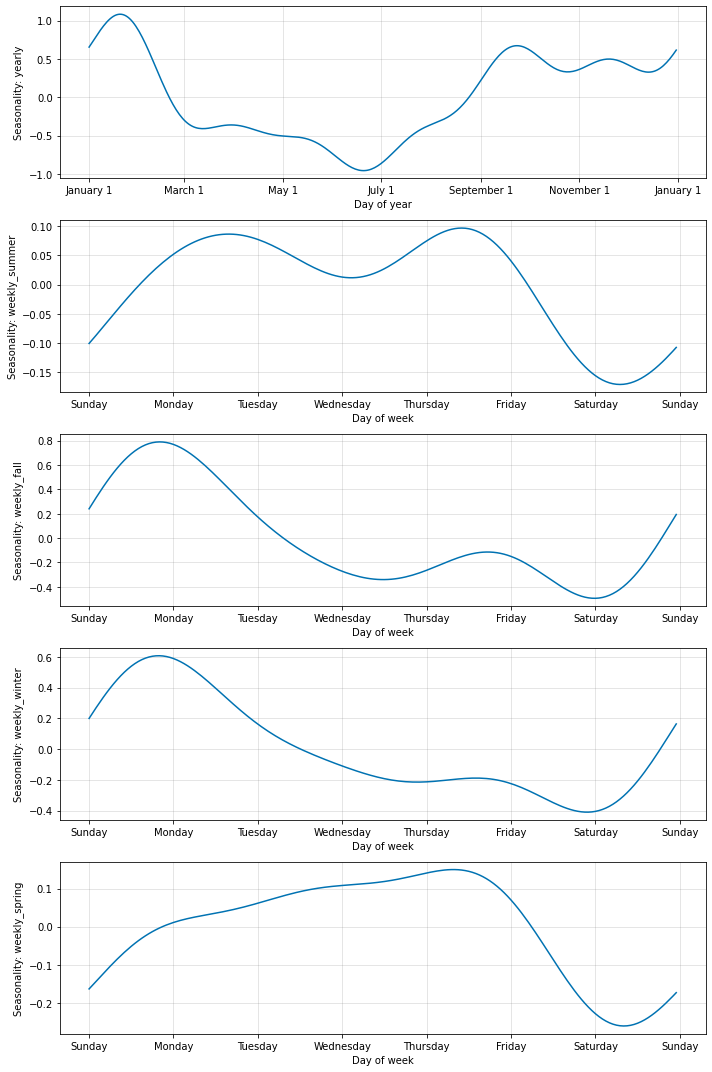

In [28]:
m.plot_parameters(components="seasonality");